In [ ]:
!pip install ipympl

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%matplotlib ipympl
import os
from random import random
import time
import scipy
import scipy.sparse.linalg
import utils

In [27]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

## Part 1 Toy Problem (20 pts)

In [ ]:
def toy_reconstruct(img):
    """
    The implementation for gradient domain processing is not complicated, but it is easy to make a mistake, so let's start with a toy example. Reconstruct this image from its gradient values, plus one pixel intensity. Denote the intensity of the source image at (x, y) as s(x,y) and the value to solve for as v(x,y). For each pixel, then, we have two objectives:
    1. minimize (v(x+1,y)-v(x,y) - (s(x+1,y)-s(x,y)))^2
    2. minimize (v(x,y+1)-v(x,y) - (s(x,y+1)-s(x,y)))^2
    Note that these could be solved while adding any constant value to v, so we will add one more objective:
    3. minimize (v(1,1)-s(1,1))^2
    
    :param toy_img: numpy.ndarray
    """
    im_h, im_w = img.shape    #Shape: (119,110)
    im2var = np.arange(im_h * im_w).reshape(im_h, im_w)

    #For objective 1, there are (h-1)*w contraints
    #For objective 2, there are (w-1)*h constraints
    #For objective 3, there is only one constraint
    neq = (im_h - 1)*im_w + (im_w - 1)*im_h + 1 #the number of equations
    
    A = scipy.sparse.lil_matrix((neq, im_h*im_w), dtype='double') # init lil
    b = np.zeros((neq,1), dtype='double')
    e = 0

    #Objective 1, difference between each pixel and its bottom neighbor
    for x in range (im_w):
      for y in range(im_h - 1):
        A[e,im2var[y + 1][x]] = 1
        A[e,im2var[y][x]] = -1
        b[e] = img[y+1][x] - img[y][x]  
        e += 1
    
    #Objective 2, difference between each pixel and its right neighbor
    for x in range (im_w - 1):
      for y in range(im_h):
        A[e,im2var[y][x+1]] = 1
        A[e,im2var[y][x]] = -1
        b[e] = img[y][x+1] - img[y][x]  
        e += 1

    #Objective 3, same first pixel in the source and target image
    A[e,im2var[0][0]] = 1
    b[e] = img[0][0]

    v = scipy.sparse.linalg.lsqr(A.tocsr(),b, atol = 1e-7)[0]
    output_img = v.reshape(im_h,im_w)
    return output_img  

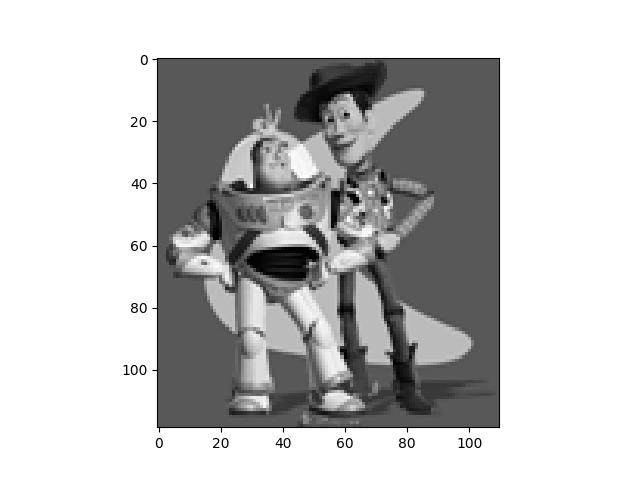

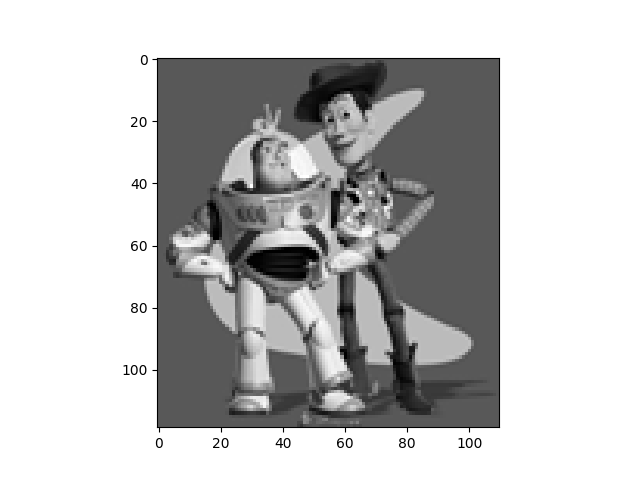

Max error is:  7.284309720184678e-05


In [ ]:
toy_img = cv2.cvtColor(cv2.imread('toy_problem.png'), cv2.COLOR_BGR2GRAY).astype('double') / 255.0
plt.imshow(toy_img, cmap="gray")
plt.show()

im_out = toy_reconstruct(toy_img)
plt.imshow(im_out, cmap="gray")
plt.show()
print("Max error is: ", np.sqrt(((im_out - toy_img)**2).max()))

## Preparation

In [ ]:
# %matplotlib ipympl
background_img = cv2.cvtColor(cv2.imread('mountain.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.figure()
plt.imshow(background_img)
plt.show()
object_img = cv2.cvtColor(cv2.imread('wolf.jpg'), cv2.COLOR_BGR2RGB).astype('double') / 255.0 
plt.imshow(object_img)
plt.show()

use_interface = True  # set to true if you want to use the interface to choose points (might not work in Colab)
if not use_interface:
  xs = (65, 359, 359, 65)
  ys = (24, 24, 457, 457)
  object_mask = utils.get_mask(ys, xs, object_img)
  bottom_center = (500, 2500) # (x,y)

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))
  
  


In [ ]:
if use_interface:
  import matplotlib.pyplot as plt
  %matplotlib ipympl
  mask_coords = utils.specify_mask(object_img)
  # Penguin: mask_coords = [[103,80,68,107,184,260,300,338,331,298,261,193,135],[180,228,307,385,437,434,379,322,251,185,104,34,94]]
  # Bear: mask_coords = [[163,120,107,94,72,78,78,96,155,184,243,288,362,386,368,365,391,399,368,368,368,304],[85,197,311,444,550,644,787,886,894,816,798,862,888,777,641,508,410,340,292,210,136,85]]
  # Wolf: 
  mask_coords = [[147,138,147,169,217,262,306,343,315,354,419,441,447,467,560,629,708,713,732,803,808,827,854,885,854,827,755,593,408,310,262,213],[144,210,285,345,413,517,581,767,804,813,804,738,623,570,539,590,672,798,813,740,701,732,751,703,572,420,296,276,272,194,135,192]]
  #Joe mask:
  # mask_coords = [[52.1,56.6,78,108,120,138,164,179,192,210,245,228,202,198,224,246,259,244,223,199,210,226,224,210,192,166,140,126,124,122,116,114,112,89,63],[147.8,162.9,174,169,154,158,151,136,138,148,144,141,134,122,117,113,107,104,106,103,88,76,66,72,89,81,83,93,67,57,74,111,146,165,154]]
  #Owl mask:
  # mask_coords = [[1364,1467,1571,1638,1699,1796,1888,1991,2095,2156,2131,2064,2003,1851,1589,1437,1370,1285,1291],[1395,1547,1639,1706,1767,1840,1870,1889,1755,1511,1206,993,719,543,512,640,847,1042,1237]]

In [ ]:
if use_interface:
  xs = mask_coords[0]
  ys = mask_coords[1]
  %matplotlib inline
  import matplotlib.pyplot as plt
  plt.figure()
  object_mask = utils.get_mask(ys, xs, object_img)

In [ ]:
if use_interface:
  %matplotlib inline
  import matplotlib.pyplot as plt
  bottom_center = utils.specify_bottom_center(background_img)
  bottom_center = [3640,3220]
  %matplotlib inline
  import matplotlib.pyplot as plt

  object_img, object_mask = utils.crop_object_img(object_img, object_mask)
  bg_ul = utils.upper_left_background_rc(object_mask, bottom_center)
  plt.figure()
  plt.imshow(utils.get_combined_img(background_img, object_img, object_mask, bg_ul))

## Part 2 Poisson Blending (50 pts)

In [22]:
def poisson_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a Poisson blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
  
    #To prevent going out of bounds:
    object_img = np.pad(object_img, pad_width=1, mode='constant',constant_values=0)
    object_mask = np.pad(object_mask, pad_width=1, mode='constant',constant_values=0)

    nnz = (object_mask>0).sum()
    
    im2var = -np.ones(object_img.shape[0:2], dtype='int32')
    im2var[object_mask>0] = np.arange(nnz) #Outside of object mask is -1's

    neq = 4*(nnz)    #The number of equations, each pixel has 4 constraint equations
    A = scipy.sparse.lil_matrix((neq,nnz), dtype='double') # init lil
    b = np.zeros((neq,1), dtype='double')
    e = 0                                       #equation counter
    x_pixels,y_pixels = np.nonzero(object_mask) #indexes of each pixel in mask
    
    
    for index in range(len(x_pixels)): #loop through each pixel in the mask
      row = x_pixels[index]
      col = y_pixels[index]
      #Bottom Neighbor
      if (im2var[row + 1][col] == -1): #on the border
        A[e,im2var[row][col]] = 1
        b[e] = object_img[row+1][col] - object_img[row][col] + bg_img[bg_ul[0] + row + 1,bg_ul[1] + col]
      else:
        A[e,im2var[row + 1][col]] = 1
        A[e,im2var[row][col]] = -1
        b[e] = object_img[row+1][col] - object_img[row][col]  
      e += 1
      #Right Neighbor
      if (im2var[row][col + 1] == -1):
        A[e,im2var[row][col]] = 1
        b[e] = object_img[row][col + 1] - object_img[row][col] + bg_img[bg_ul[0] + row,bg_ul[1] + col + 1]
      else:
        A[e,im2var[row][col+1]] = 1
        A[e,im2var[row][col]] = -1
        b[e] = object_img[row][col+1] - object_img[row][col]  
      e += 1
      #Left Neighbor
      if (im2var[row][col - 1] == -1):
        A[e,im2var[row][col]] = 1
        b[e] = object_img[row][col - 1] - object_img[row][col] + bg_img[bg_ul[0] + row,bg_ul[1] + col - 1]
      else:
        A[e,im2var[row][col-1]] = 1
        A[e,im2var[row][col]] = -1
        b[e] = object_img[row][col-1] - object_img[row][col]  
      e += 1
      #Upper Neighbor
      if (im2var[row - 1][col] == -1): #on the border
        A[e,im2var[row][col]] = 1
        b[e] = object_img[row - 1][col] - object_img[row][col] + bg_img[bg_ul[0] + row - 1,bg_ul[1] + col]
      else:
        A[e,im2var[row - 1][col]] = 1
        A[e,im2var[row][col]] = -1
        b[e] = object_img[row - 1][col] - object_img[row][col]  
      e += 1

    v = scipy.sparse.linalg.lsqr(A.tocsr(),b)[0]
    fusion = object_img * object_mask
    counter = 0
    for index in range(len(x_pixels)):
      col = y_pixels[index]
      row = x_pixels[index]
      fusion[row][col] = v[counter]
      counter += 1

    plt.figure()
    plt.imshow(fusion)

    for index in range(len(x_pixels)):
      col = y_pixels[index]
      row = x_pixels[index]
      bg_img[bg_ul[0] + row,bg_ul[1] + col] = fusion[row][col]
    return bg_img



In [ ]:
im_blend = np.zeros(background_img.shape)

im_blendr = poisson_blend(object_img[:,:,0], object_mask, background_img[:,:,0].copy(), bg_ul)
im_blendg = poisson_blend(object_img[:,:,1], object_mask, background_img[:,:,1].copy(), bg_ul)
im_blendb = poisson_blend(object_img[:,:,2], object_mask, background_img[:,:,2].copy(), bg_ul)
im_blend = cv2.merge((im_blendr, im_blendg, im_blendb))

plt.figure()
plt.imshow(im_blend)


## Part 3 Mixed Gradients (20 pts)

In [71]:
def mixed_blend(object_img, object_mask, bg_img, bg_ul):
    """
    Returns a mixed gradient blended image with masked object_img over the bg_img at position specified by bg_ul.
    Can be implemented to operate on a single channel or multiple channels
    :param object_img: the image containing the foreground object
    :param object_mask: the mask of the foreground object in object_img
    :param background_img: the background image 
    :param bg_ul: position (row, col) in background image corresponding to (0,0) of object_img 
    """
    #TO DO
    object_img = np.pad(object_img, pad_width=1, mode='constant',constant_values=0)
    object_mask = np.pad(object_mask, pad_width=1, mode='constant',constant_values=0)

    nnz = (object_mask>0).sum()
    
    im2var = -np.ones(object_img.shape[0:2], dtype='int32')
    im2var[object_mask>0] = np.arange(nnz) #Outside of object mask is -1's

    neq = 4*(nnz)    #The number of equations, each pixel has 4 constraint equations
    A = scipy.sparse.lil_matrix((neq,nnz), dtype='double') # init lil
    b = np.zeros((neq,1), dtype='double')
    e = 0                                       #equation counter
    x_pixels,y_pixels = np.nonzero(object_mask) #indexes of each pixel in mask
    
    
    for index in range(len(x_pixels)): #loop through each pixel in the mask
      row = x_pixels[index]
      col = y_pixels[index]
      #Bottom Neighbor
      s_gradient = object_img[row,col] - object_img[row+1,col]
      t_gradient = bg_img[row,col] - bg_img[row+1,col]
      gradient = max(abs(s_gradient),abs(t_gradient))
      if (im2var[row + 1][col] == -1): #on the border
        A[e,im2var[row][col]] = 1
        b[e] = gradient + bg_img[bg_ul[0] + row + 1,bg_ul[1] + col]
      else:
        A[e,im2var[row + 1][col]] = 1
        A[e,im2var[row][col]] = -1
        b[e] = gradient 
      e += 1
      #Right Neighbor
      s_gradient = object_img[row,col] - object_img[row,col + 1]
      t_gradient = bg_img[row,col] - bg_img[row,col + 1]
      gradient = max(abs(s_gradient),abs(t_gradient))
      if (im2var[row][col + 1] == -1):
        A[e,im2var[row][col]] = 1
        b[e] = gradient + bg_img[bg_ul[0] + row,bg_ul[1] + col + 1]
      else:
        A[e,im2var[row][col+1]] = 1
        A[e,im2var[row][col]] = -1
        b[e] = gradient
      e += 1
      #Left Neighbor
      s_gradient = object_img[row,col] - object_img[row,col - 1]
      t_gradient = bg_img[row,col] - bg_img[row,col - 1]
      gradient = max(abs(s_gradient),abs(t_gradient))
      if (im2var[row][col - 1] == -1):
        A[e,im2var[row][col]] = 1
        b[e] = gradient + bg_img[bg_ul[0] + row,bg_ul[1] + col - 1]
      else:
        A[e,im2var[row][col-1]] = 1
        A[e,im2var[row][col]] = -1
        b[e] = gradient  
      e += 1
      #Upper Neighbor
      s_gradient = object_img[row,col] - object_img[row- 1,col]
      t_gradient = bg_img[row,col] - bg_img[row - 1,col]
      gradient = max(abs(s_gradient),abs(t_gradient))
      if (im2var[row - 1][col] == -1): #on the border
        A[e,im2var[row][col]] = 1
        b[e] = gradient + bg_img[bg_ul[0] + row - 1,bg_ul[1] + col]
      else:
        A[e,im2var[row - 1][col]] = 1
        A[e,im2var[row][col]] = -1
        b[e] = gradient  
      e += 1

    v = scipy.sparse.linalg.lsqr(A.tocsr(),b)[0]
    fusion = object_img * object_mask
    counter = 0
    for index in range(len(x_pixels)):
      col = y_pixels[index]
      row = x_pixels[index]
      fusion[row][col] = v[counter]
      counter += 1

    plt.figure()
    plt.imshow(fusion)

    for index in range(len(x_pixels)):
      col = y_pixels[index]
      row = x_pixels[index]
      bg_img[bg_ul[0] + row,bg_ul[1] + col] = fusion[row][col]
    return bg_img


In [ ]:
im_mix = np.zeros(background_img.shape)

im_mixr = mixed_blend(object_img[:,:,0], object_mask, background_img[:,:,0].copy(), bg_ul)
im_mixg = mixed_blend(object_img[:,:,1], object_mask, background_img[:,:,1].copy(), bg_ul)
im_mixb = mixed_blend(object_img[:,:,2], object_mask, background_img[:,:,2].copy(), bg_ul)
im_mix = cv2.merge((im_mixr, im_mixg, im_mixb))

plt.figure()
plt.imshow(im_mix)


# Bells & Whistles (Extra Points)

## Color2Gray (20 pts)

In [ ]:
def color2gray(img):
    pass

## Laplacian pyramid blending (20 pts)

In [ ]:
def laplacian_blend(object_img, object_mask, bg_img, bg_ul):
  # feel free to change input parameters
    pass

## More gradient domain processing (up to 20 pts)